<a href="https://colab.research.google.com/github/seoggu/handwritten_number_classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [24]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1+cu116


'cpu'

## 5. Load test dataset

7


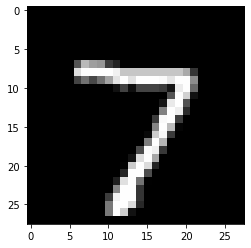

In [14]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = MNIST(root="data",
              train=True,
              download=True,
              transform=ToTensor()
              )

test_data = MNIST(root="data",
              train=False,
              download=True,
              transform=ToTensor()
              )
next(enumerate(test_data))

plt.imshow(next(enumerate(test_data))[1][0].squeeze(), cmap="gray");
print(next(enumerate(test_data))[1][1])

In [15]:
classidx = train_data.class_to_idx

## 6. Visualize training dataset.

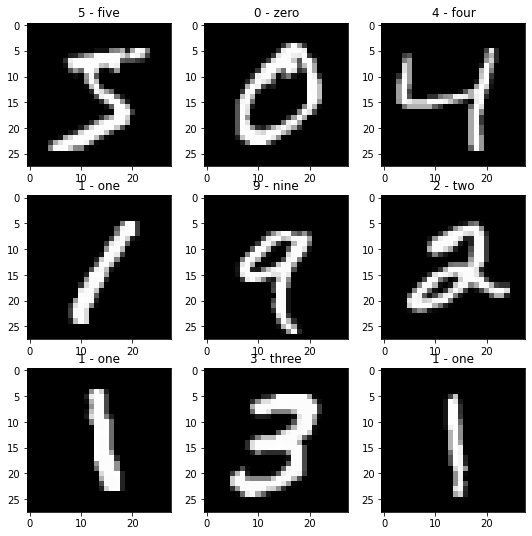

In [16]:

fig = plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i, (image, target) in enumerate(train_data):
  if i <9:
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(train_data.classes[target])

##  Turn the train and test datasets into dataloaders

In [17]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader = DataLoader(dataset= train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset= test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7f701e2040>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7f70172dc0>)

In [18]:
train_data[59999][0].shape


torch.Size([1, 28, 28])

In [19]:
from torch import nn

class Model_V0(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    z = self.conv_block1(x)
    # print(z.shape)
    z= self.conv_block2(z)
    # print(z.shape)
    z= self.classifier(z)
    # print(z.shape)
    return z



In [25]:
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)


model_2 = Model_V0(input_shape=1,
                   output_shape=len(classidx),
                   hidden_units=10).to(device)
model_2

Model_V0(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [26]:
next(enumerate(test_data))[1][0].to(device).shape

torch.Size([1, 28, 28])

In [27]:
dummy_tensor = torch.randn([2,1,28,28])
dummy_tensor.shape

torch.Size([2, 1, 28, 28])

In [28]:
model_2(dummy_tensor.to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185],
        [ 0.0358, -0.0907,  0.0761, -0.0497,  0.0093,  0.0326,  0.0156, -0.0088,
         -0.0064, -0.0145]], grad_fn=<AddmmBackward0>)

#import helper functions

In [29]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("already exist")
else:
    print("download")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

download


In [30]:
from helper_functions import accuracy_fn

## Train the model for 5 epochs on CPU and GPU and see how long it takes on each.

#Functions

In [31]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """prints difference between start and end time."""
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  train_loss, train_acc = 0,0

  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(dim=1))
    train_loss += loss
    train_acc += acc
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}&")

In [33]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
  test_loss, test_acc = 0,0

  model.eval()
  for X,y in data_loader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(dim=1))
    
    test_loss += loss
    test_acc += acc
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}&")

In [34]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}

#optimizer, loss function

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

#training loop

In [36]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

time_start = timer()

epochs=5

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}\n-----------")

  train_step(model=model_2,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             data_loader=train_dataloader,
             device=device)

  test_step(model=model_2,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             data_loader=test_dataloader,
             device=device)


time_end = timer()
total_time = print_train_time(start=time_start,
                              end=time_end,
                              device=str(next(model_2.parameters()).device))


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0
-----------
Train loss: 0.33561 | Train acc: 88.74&
Test loss: 0.07467 | Test acc: 97.61&
Epoch:1
-----------
Train loss: 0.07959 | Train acc: 97.48&
Test loss: 0.05153 | Test acc: 98.25&
Epoch:2
-----------
Train loss: 0.06256 | Train acc: 98.04&
Test loss: 0.04446 | Test acc: 98.39&
Epoch:3
-----------
Train loss: 0.05446 | Train acc: 98.29&
Test loss: 0.03786 | Test acc: 98.74&
Epoch:4
-----------
Train loss: 0.04919 | Train acc: 98.46&
Test loss: 0.03465 | Test acc: 98.70&
Train time on cpu: 314.650 seconds


In [37]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_2_results 

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'Model_V0',
 'model_loss': 0.03146817162632942,
 'model_acc': 98.95167731629392}

##  Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [38]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [39]:
import random
# random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].unsqueeze(dim=0).shape



torch.Size([1, 1, 28, 28])

In [40]:
model_2(test_samples[0].unsqueeze(dim=0).to(device))

tensor([[16.9147, -3.6146,  7.1850, -6.5806, -9.0007, -5.4754,  2.4431, -9.4457,
          4.3595, -0.2976]], grad_fn=<AddmmBackward0>)

In [41]:
torch.softmax(model_2(test_samples[0].unsqueeze(dim=0).to(device)).squeeze(), dim=0)

tensor([9.9994e-01, 1.2139e-09, 5.9484e-05, 6.2529e-11, 5.5597e-12, 1.8882e-10,
        5.1882e-07, 3.5625e-12, 3.5261e-06, 3.3477e-08],
       grad_fn=<SoftmaxBackward0>)

In [42]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)
pred_probs[:2]

tensor([[9.9994e-01, 1.2139e-09, 5.9484e-05, 6.2529e-11, 5.5597e-12, 1.8882e-10,
         5.1882e-07, 3.5625e-12, 3.5261e-06, 3.3477e-08],
        [9.9992e-01, 6.2549e-13, 2.8997e-08, 2.1023e-10, 3.1040e-15, 7.1519e-10,
         7.5236e-05, 1.8443e-12, 3.2322e-10, 6.5264e-07]])

In [43]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([0, 0, 8, 1, 6, 2, 1, 6, 1]), [0, 0, 8, 1, 6, 2, 1, 6, 1])

In [44]:
classidx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [45]:
class_name = list(classidx.keys())
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

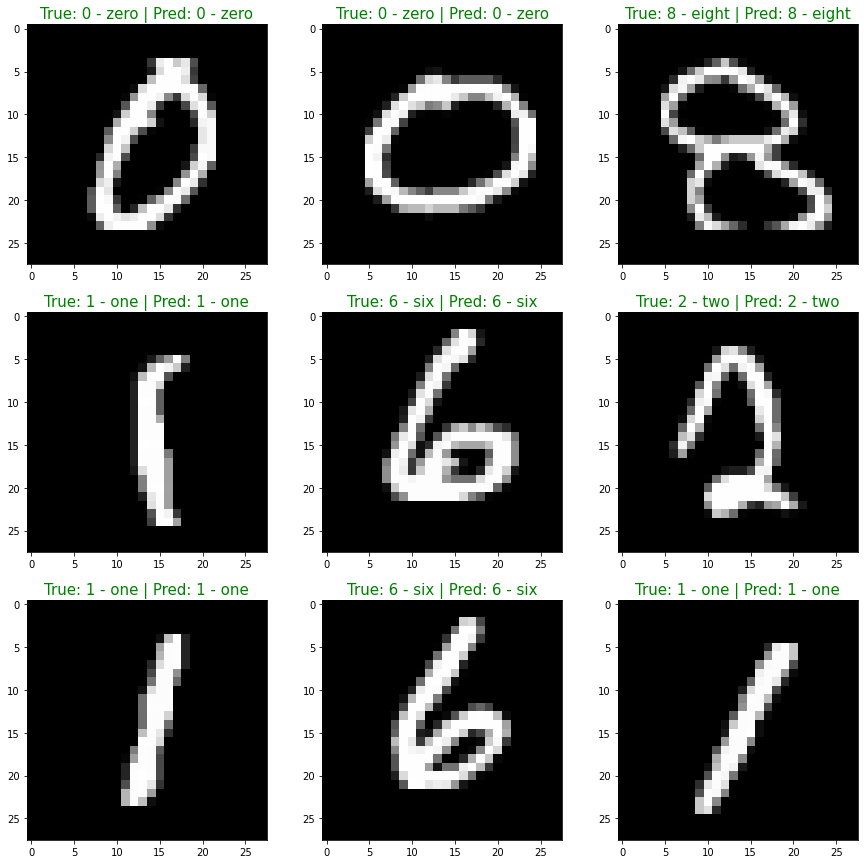

In [46]:
plt.figure(figsize=(15,15))
nrows=3
ncols=3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_name[pred_classes[i]]
  true_label = class_name[test_labels[i]]
  title_text = f"True: {true_label} | Pred: {pred_label}"

  if pred_label == true_label:
    plt.title(title_text, fontsize=15, c="g")
  else:
    plt.title(title_text, fontsize=15, c="r")

##  Plot a confusion matrix comparing your model's predictions to the truth labels.

get prediction tensor

In [47]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)
    y_logits = model_2(X)

    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds).cpu()
y_preds_tensor, test_data.targets

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

(tensor([7, 2, 1,  ..., 4, 5, 6]), tensor([7, 2, 1,  ..., 4, 5, 6]))

In [48]:
len(y_preds_tensor), len(test_data.targets)

(10000, 10000)

import torchmetrics,  mlxtend

In [49]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version:{mlxtend.__version__}")
    assert int(mlxtend.__version__.split("."[1] >= 19, "mlxtend version should be 0.19.0 or higher"))
except:
    !pip install torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version: 0.21.0


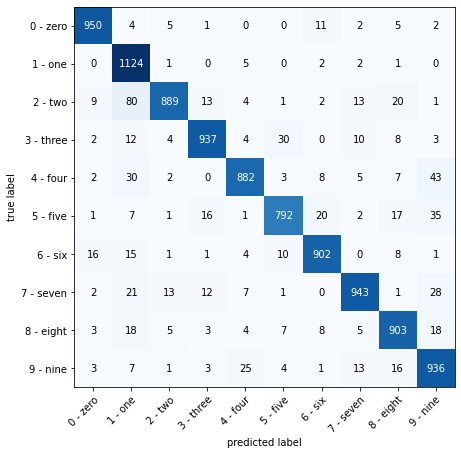

In [50]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_name))

confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize=(10,7)
)

## Save model


In [52]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "number_classifier_v0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/number_classifier_v0.pth


#Load model

In [53]:
loaded_model = Model_V0(input_shape=1,
                        hidden_units=10,
                        output_shape=len(class_name))

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

Model_V0(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)